# MobileNetV3
deeplearning approach to auto-ROI detection

Important installations for mounting the dataset from kaggle & other needed libraries

In [ ]:
# Propper installation and kaggle link for the dataset!
!pip install kaggle
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!kaggle datasets download -d thomasfermi/lane-detection-for-carla-driving-simulator
!unzip lane-detection-for-carla-driving-simulator.zip -d /content/carla_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2318.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2319.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_232.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2320.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2321.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2322.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2323.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2324.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2325.png  
  inflating: /content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_

In [ ]:
!pip install fastseg
!pip install fastai --upgrade
!pip install fastseg
!pip install fastai --upgrade
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 164.3 kB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import albumentations  as albu
import os
import copy
albu.__version__
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
def plot_images_in_folder(folder_path, num_images=5):
    """
    Plot a given number of images from a folder using Matplotlib.

    Parameters:
    - folder_path (str): Path to the folder containing images.
    - num_images (int): Number of images to plot. Default is 5.
    """
    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    # Ensure the number of requested images is within the available range
    num_images = min(num_images, len(image_files))

    # Create a subplot with the specified number of rows and columns
    rows = (num_images // 3) + (num_images % 3)
    cols = min(num_images, 3)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

    # Plot each image
    for i in range(num_images):
        img_path = os.path.join(folder_path, image_files[i])
        img = mpimg.imread(img_path)

        # For a single image, axes is not an array
        if num_images == 1:
            axes.imshow(img)
            axes.axis('off')
        else:
            axes[i // cols, i % cols].imshow(img)
            axes[i // cols, i % cols].axis('off')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()


Plotting the custom environment images

Custom Images


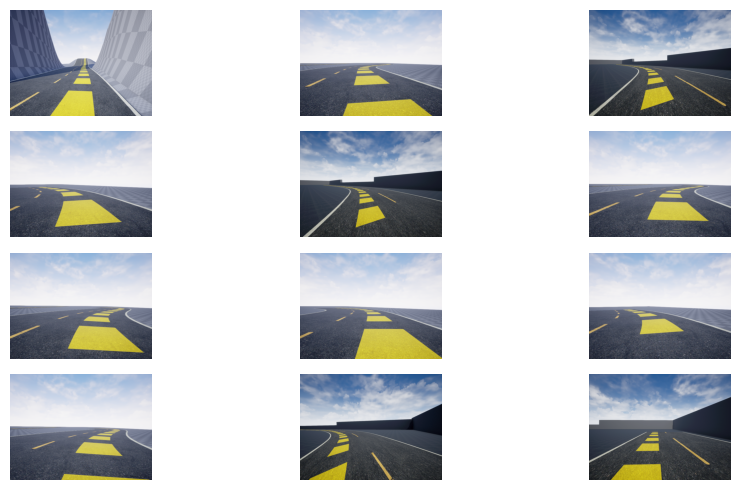

In [ ]:
folder_path = "/content/custom/train"
num_images_to_plot = 12
print('Custom Images')
plot_images_in_folder(folder_path, num_images_to_plot)

These are an example of the images from the custom environment that are added to the dataset to familiarize the model with the environment

Changing the images of dataset from RGB with 3 channels for R G B to 1 channel
so the new dimension will be H x W x 1

This is for the training images.
train_gray is the name of the created folder

In [ ]:
def process_images(src_folder, dest_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get a list of all files in the source folder
    image_files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        # Construct the full path of the input image
        input_path = os.path.join(src_folder, image_file)

        # Load the RGB image
        image_rgb = cv2.imread(input_path)

        if image_rgb is not None:
            # Convert RGB image to grayscale
            image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

            # Reshape the grayscale image to have dimensions H x W x 1
            image_reshaped = np.expand_dims(image_gray, axis=2)

            # Construct the full path of the output image
            output_path = os.path.join(dest_folder, image_file)

            # Save the reshaped image as a PNG with a single channel
            cv2.imwrite(output_path, image_reshaped, [cv2.IMWRITE_PNG_COMPRESSION, 0])

            print(f"Processed and saved: {output_path}")

# converting and saving converted-reshaped images in dest folder
source_folder = '/content/carla_dataset/train'
destination_folder = '/content/carla_dataset/train_gray'

process_images(source_folder, destination_folder)


Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_233.png
Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_3053.png
Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2818.png
Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_463.png
Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2060.png
Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1982.png
Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1791.png
Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2432.png
Processed and saved: /content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1448.png
Processed and saved: /content/

In [ ]:
def process_images(src_folder, dest_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get a list of all files in the source folder
    image_files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        # Construct the full path of the input image
        input_path = os.path.join(src_folder, image_file)

        # Load the RGB image
        image_rgb = cv2.imread(input_path)

        if image_rgb is not None:
            # Convert RGB image to grayscale
            image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

            # Reshape the grayscale image to have dimensions H x W x 1
            image_reshaped = np.expand_dims(image_gray, axis=2)

            # Construct the full path of the output image
            output_path = os.path.join(dest_folder, image_file)

            # Save the reshaped image as a PNG with a single channel
            cv2.imwrite(output_path, image_reshaped, [cv2.IMWRITE_PNG_COMPRESSION, 0])

            print(f"Processed and saved: {output_path}")

# converting and saving converted-reshaped images in dest folder
source_folder = '/content/carla_dataset/train_label'
destination_folder = '/content/carla_dataset/train_label_gray'

process_images(source_folder, destination_folder)


Processed and saved: /content/carla_dataset/train_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2169_label.png
Processed and saved: /content/carla_dataset/train_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_490_label.png
Processed and saved: /content/carla_dataset/train_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_3181_label.png
Processed and saved: /content/carla_dataset/train_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_21_label.png
Processed and saved: /content/carla_dataset/train_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2816_label.png
Processed and saved: /content/carla_dataset/train_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1794_label.png
Processed and saved: /content/carla_dataset/train_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_287_label.png
Processed and saved: /content/carla_dataset/train_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2992_label.png
Processed and saved: /content/carla_dataset/

This is for the vaidations images.
val_gray is the name for the new validation images.

In [ ]:
def process_images(src_folder, dest_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get a list of all files in the source folder
    image_files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        # Construct the full path of the input image
        input_path = os.path.join(src_folder, image_file)

        # Load the RGB image
        image_rgb = cv2.imread(input_path)

        if image_rgb is not None:
            # Convert RGB image to grayscale
            image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

            # Reshape the grayscale image to have dimensions H x W x 1
            image_reshaped = np.expand_dims(image_gray, axis=2)

            # Construct the full path of the output image
            output_path = os.path.join(dest_folder, image_file)

            # Save the reshaped image
            cv2.imwrite(output_path, image_reshaped)

            print(f"Processed and saved: {output_path}")

# converting and saving converted-reshaped imahges in dest folder
source_folder = '/content/carla_dataset/val'
destination_folder = '/content/carla_dataset/val_gray'

process_images(source_folder, destination_folder)

Processed and saved: /content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_631_validation_set.png
Processed and saved: /content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_623_validation_set.png
Processed and saved: /content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_3145_validation_set.png
Processed and saved: /content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_91_validation_set.png
Processed and saved: /content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_946_validation_set.png
Processed and saved: /content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1885_validation_set.png
Processed and saved: /content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1284_validation_set.png
Processed and saved: /content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_147_validation_set.png
Processed and saved: /content/carla_da

In [ ]:
def process_images(src_folder, dest_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get a list of all files in the source folder
    image_files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        # Construct the full path of the input image
        input_path = os.path.join(src_folder, image_file)

        # Load the RGB image
        image_rgb = cv2.imread(input_path)

        if image_rgb is not None:
            # Convert RGB image to grayscale
            image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

            # Reshape the grayscale image to have dimensions H x W x 1
            image_reshaped = np.expand_dims(image_gray, axis=2)

            # Construct the full path of the output image
            output_path = os.path.join(dest_folder, image_file)

            # Save the reshaped image as a PNG with a single channel
            cv2.imwrite(output_path, image_reshaped, [cv2.IMWRITE_PNG_COMPRESSION, 0])

            print(f"Processed and saved: {output_path}")

# converting and saving converted-reshaped images in dest folder
source_folder = '/content/carla_dataset/val_label'
destination_folder = '/content/carla_dataset/val_label_gray'

process_images(source_folder, destination_folder)


Processed and saved: /content/carla_dataset/val_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_630_validation_set_label.png
Processed and saved: /content/carla_dataset/val_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_948_validation_set_label.png
Processed and saved: /content/carla_dataset/val_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_636_validation_set_label.png
Processed and saved: /content/carla_dataset/val_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1203_validation_set_label.png
Processed and saved: /content/carla_dataset/val_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_90_validation_set_label.png
Processed and saved: /content/carla_dataset/val_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_929_validation_set_label.png
Processed and saved: /content/carla_dataset/val_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1171_validation_set_label.png
Processed and saved: /content/carla_dataset/val_label_gray/Town04_Clear_Noo

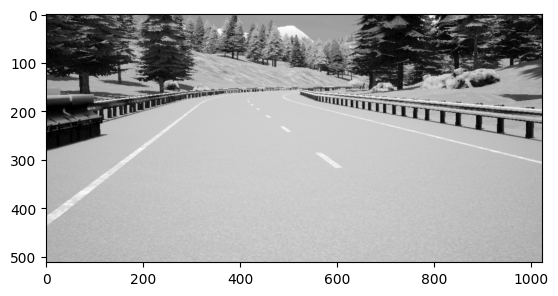

(512, 1024)


In [ ]:

folder_path = '/content/carla_dataset/train_gray'

# Check if the folder path exists
if not os.path.exists(folder_path):
    print("Folder does not exist.")
else:
    # Get a list of all files in the folder
    all_files = os.listdir(folder_path)

    # Filter out only the image files (you can extend the list if needed)
    image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    # Check if there are any image files in the folder
    if not image_files:
        print("No image files found in the folder.")
    else:
        random_image = random.choice(image_files)
        random_image_path = os.path.join(folder_path, random_image)


image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')
plt.show()
print(image.shape)

These are needed funcitons that are fed to the dataloader to feed an image with corresponding mask as a label

In [ ]:

def label_func(fn):
    return str(fn).replace(".png", "_label.png").replace("train", "train_label").replace("val/", "val_label/") # change

def label_func_gray(fn):
    return str(fn).replace(".png", "_label.png").replace("train_gray", "train_label_gray").replace("val_gray/", "val_label_gray/") # change

def label_func_custom(fn):
    return str(fn).replace(".png", "_label.png").replace("train_custom", "train_custom_label").replace("val_custom/", "val_custom_label/") # change



/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


(512, 1024)


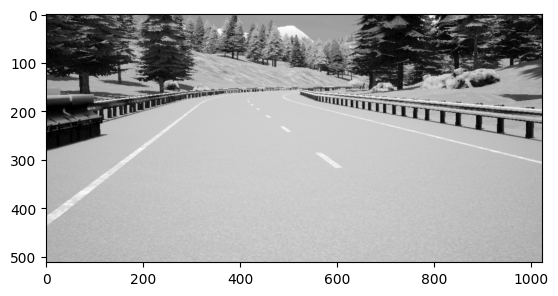

In [ ]:
fn = '/content/carla_dataset/train_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png'
img = get_gray_images(fn)
print(img.shape)
plt.imshow(img,cmap='gray')
plt.show()


Defining the dataset directory and the function that will apply augmentations and feed images and masks to the dataloader 

In [ ]:

DATA_DIR = "/content/carla_dataset"

x_train_dir_gray = os.path.join(DATA_DIR, 'train')
y_train_dir_gray = os.path.join(DATA_DIR, 'train_label')

x_valid_dir_gray = os.path.join(DATA_DIR, 'val')
y_valid_dir_gray = os.path.join(DATA_DIR, 'val_label')


In [ ]:
# Using partial to pass the folder names for the dataset 
my_get_image_files = partial(get_image_files, folders=['train', 'val'])

Defining a class to perform augmentations on images as they are fed to the model through the dataloader

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])


albu_transform_list = [
    albu.IAAAdditiveGaussianNoise(p=0.2),
    albu.OneOf(
        [
            albu.CLAHE(p=1),
            albu.RandomBrightness(p=1),
            albu.RandomGamma(p=1),
        ],
        p=0.6,
    ),
    albu.OneOf(
        [
            albu.IAASharpen(p=1),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.6,
    ),
    albu.OneOf(
        [
            albu.RandomContrast(p=1),
            albu.HueSaturationValue(p=1),
        ],
        p=0.6,
    ),
]
albu_transform = albu.Compose(albu_transform_list)


def get_pred_for_mobilenet(model, img_array):
    with torch.no_grad():
        image_tensor = img_array.transpose(2,0,1).astype('float32')/255
        x_tensor = torch.from_numpy(image_tensor).to("cuda").unsqueeze(0)
        model_output = F.softmax( model.forward(x_tensor), dim=1 ).cpu().numpy()
    return model_output

def extract_lane_boundaries(left_mask, right_mask, threshold=0.3):
    '''
    This function extracts the boundaries of the left and right lanes from the prediction that is overlaid on image 
    to use later for ROI isolation
    '''
    # Threshold the masks to separate left and right lanes
    left_lane = (left_mask > threshold).astype(np.uint8)
    right_lane = (right_mask > threshold).astype(np.uint8)
    left_boundary = left_lane.copy() # Taking a copy of the extracted boundaries
    right_boundary = right_lane.copy()

    # Find the boundary of the left lane
    contours, _ = cv2.findContours(left_boundary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        left_boundary = cv2.drawContours(left_boundary, contours, -1, (1), thickness=cv2.FILLED)

    # Find the boundary of the right lane
    contours, _ = cv2.findContours(right_boundary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        right_boundary = cv2.drawContours(right_boundary, contours, -1, (1), thickness=cv2.FILLED)

    return left_boundary, right_boundary

In [ ]:
'''
Creating a custom function that ensures that all images are of the same size and the masks as well 
'''
folder_path = '/content/carla_dataset/val_label'

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(folder_path, filename)

        # Open the image using PIL
        img = Image.open(image_path)

        # Check if the image size matches the desired dimensions
        if img.size == (224, 224):
            continue  # Skip if already the desired size

        # Resize the image
        resized_image = img.resize((224, 224))

        # Save the resized image, overwriting the original
        resized_image.save(image_path)

print("Resizing and replacing images complete.")

Resizing and replacing images complete.


In [ ]:
codes = np.array(['back', 'left','right'],dtype=str)

Creating the datablock that will be used by the dataloader to feed images and masks to the model during the fine tuning phase

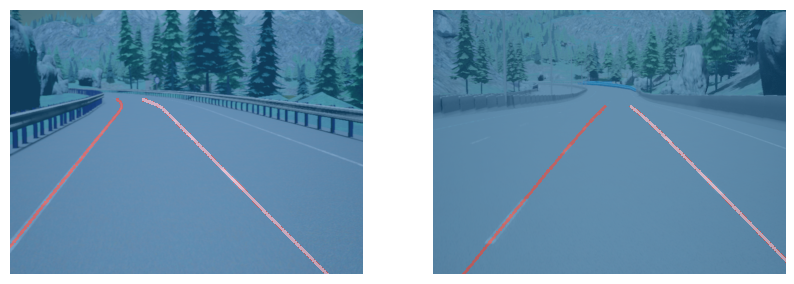

In [ ]:
carla = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = my_get_image_files, # modifoy inn this function to have it pull images that are grayscale
                   get_y = label_func,
                   splitter = FuncSplitter(lambda x: str(x).find('validation_set')!=-1),
                  item_tfms=[SegmentationAlbumentationsTransform(albu_transform)])
dls = carla.dataloaders(Path(DATA_DIR), bs=2,path=Path("."), shuffle= True)
dls.show_batch(max_n=6, figsize=(10, 6))  # Adjust figsize as needed

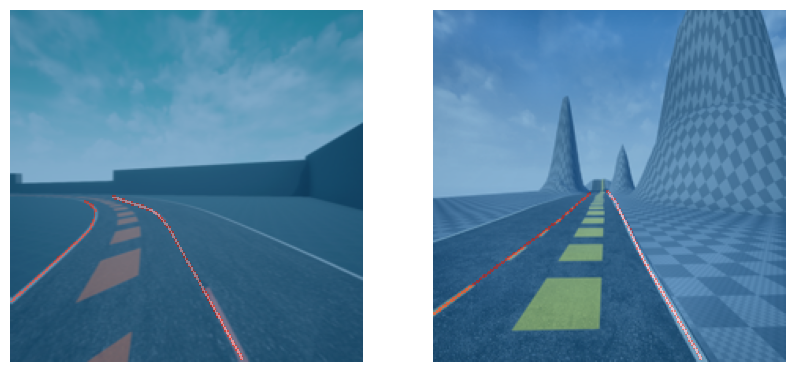

In [ ]:
carla = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = my_get_image_files, # modifoy inn this function to have it pull images that are grayscale
                   get_y = label_func,
                   splitter = FuncSplitter(lambda x: str(x).find('validation_set')!=-1),
                   item_tfms=[SegmentationAlbumentationsTransform(albu_transform)])
dls = carla.dataloaders(Path(DATA_DIR_custom),path=Path("."), bs=2,shuffle = True)
dls.show_batch(max_n=6, figsize=(10, 6))  # Adjust figsize as needed

### Importing the important libraries for MobileNetV3small model & loading the model

In [ ]:
from fastseg import MobileV3Small  # Assuming you meant MobileNetV3Small
from fastai.vision.all import *

model = MobileV3Small(num_classes=3, use_aspp=True, num_filters=8)
learn = Learner(dls, model, metrics=[DiceMulti()])
# Printing model summary
learn.summary()


MobileV3Small (Input shape: 2 x 3 x 960 x 1280)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 16 x 480 x 640  
Conv2dSame                                432        True      
BatchNorm2d                               32         True      
HardSwishMe                                                    
____________________________________________________________________________
                     2 x 16 x 240 x 320  
Conv2dSame                                144        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     2 x 8 x 1 x 1       
Conv2d                                    136        True      
ReLU                                                           
____________________________________________________________________________
                   

In [ ]:
# Clearing the CUDA cache to ensure that we have enough memory for training
torch.cuda.empty_cache()

In [ ]:
# Fine tuning the model on all dataset for 5 epochs
learn.fine_tune(5)

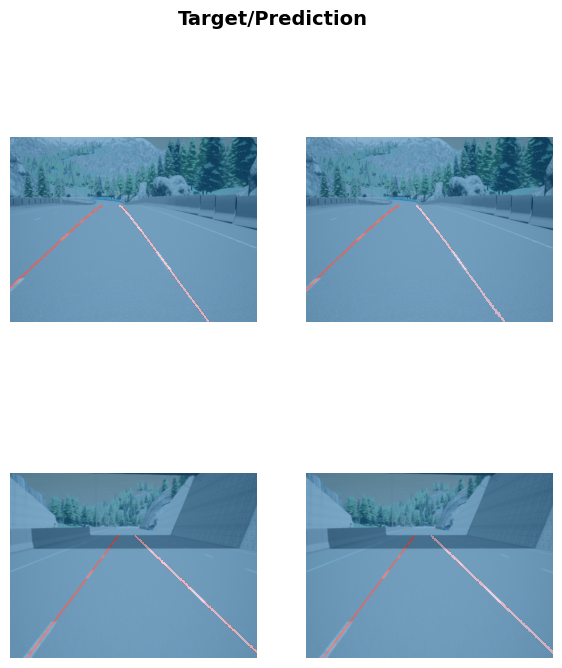

In [ ]:
learn.show_results(max_n=200, figsize=(7,8))
torch.save(learn.model, '/content/fast_seg_model_custom_latest.pth')

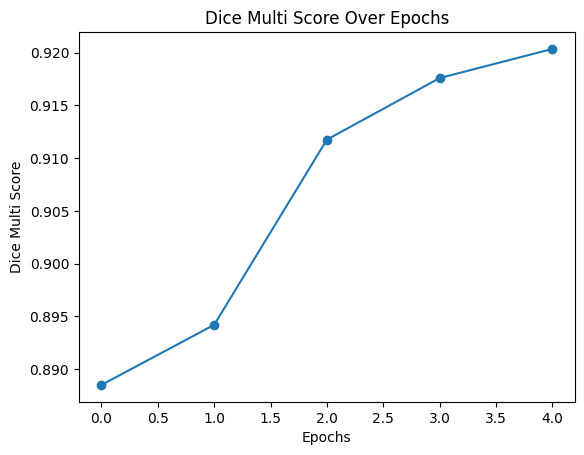

In [ ]:

# Extracting the dice_multi values from the fine-tuning results
epochs = [0, 1, 2, 3, 4]
dice_multi_values = [0.888487, 0.894188, 0.911759, 0.917599, 0.920365]

# Plotting the dice_multi values
plt.plot(epochs, dice_multi_values, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Dice Multi Score')
plt.title('Dice Multi Score Over Epochs')
plt.show()


In [ ]:
# Printing the model evaluation scores on the validation set after fine-tuning
x = learn.validate()
print(x)

[0.007764613721519709, 0.9203646726888226]


In [ ]:
print("Validation loss = ",x[0])
print("Validation Dice_Multi = ",x[1])

Validation loss =  0.007764613721519709
Validation Dice_Multi =  0.9203646726888226


showing results of the model on the validation dataset

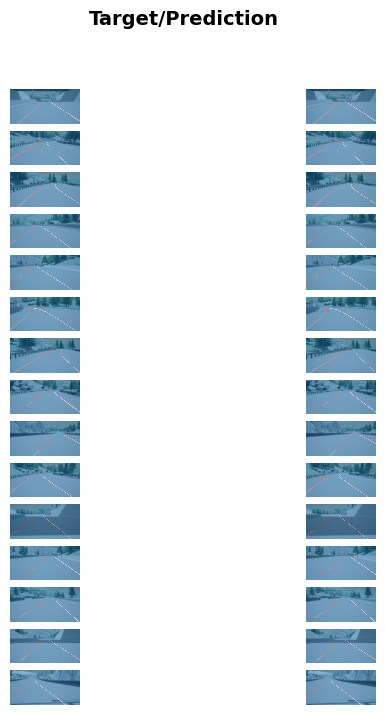

In [ ]:
learn.show_results(max_n=200, figsize=(7,8))
# Saving the model
torch.save(learn.model, '/content/fast_seg_model_final.pth')

Testing the model prediction on custom images

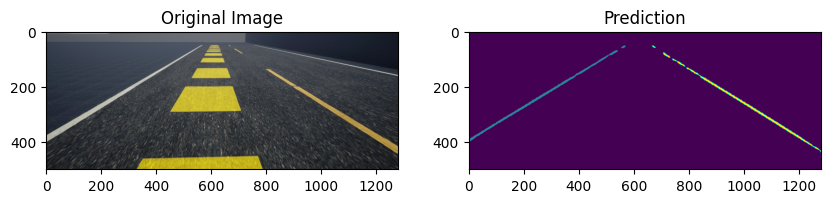

CPU times: user 1.56 s, sys: 212 ms, total: 1.77 s
Wall time: 742 ms


In [ ]:
%%time
#img = cv2.imread(str(get_image_files(x_valid_dir)[5]))
img = cv2.imread('/content/cropped_image_bottom.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
original_file_name, extension = os.path.splitext(img.name)
# Original RGB Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Reshaped Grayscale Image
plt.subplot(1, 2, 2)
plt.imshow(np.array(learn.predict(img)[1]))
plt.title('Prediction')

plt.show()
# Assuming img is the input image
output_array = np.array(learn.predict(img)[1])

# Convert the data type to uint8
output_array = output_array.astype(np.uint8)

# Convert the NumPy array to a PIL Image
output_image = Image.fromarray(output_array)

# Save the image to a file
output_image.save('output_image.png')

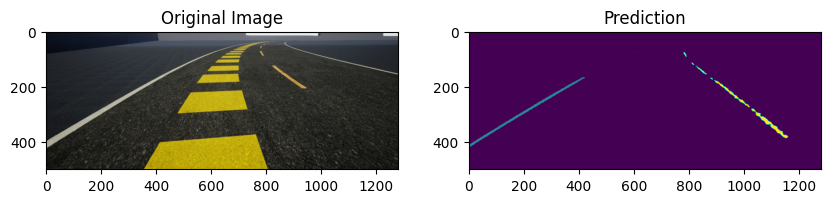

In [ ]:
# Load the image
img = cv2.imread('/content/cropped_image_bottom.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the original and predicted images
plt.figure(figsize=(10, 5))

# Original RGB Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Prediction
prediction = np.array(learn.predict(img)[1])
plt.subplot(1, 2, 2)
plt.imshow(prediction)
plt.title('Prediction')

plt.show()

# Save the predicted image with the same name as the input image
original_file_name, extension = os.path.splitext('/content/cropped_image_bottom.jpg')
output_file_name = f"{original_file_name}_label{extension}"

# Convert the data type to uint8
prediction = prediction.astype(np.uint8)

# Convert the NumPy array to a PIL Image
output_image = Image.fromarray(prediction)

# Save the image to a file with the modified name
output_image.save(output_file_name)

In [ ]:
# Save the padded image in a specific directory
output_directory = '/content/output_images/'  # Replace with your desired directory

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Save the padded image with the same name as the input image
original_file_name, extension = os.path.splitext('/content/cropped_image_bottom_label.jpg')
output_file_name = f"{original_file_name}{extension}"
output_path = os.path.join(output_directory, output_file_name)

# Convert the NumPy array to a PIL Image
output_image = Image.fromarray(padded_img)

# Save the padded image to the specified directory with the modified name
output_image.save(output_path)

Testing time for predictions 

71.6 ms ± 619 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


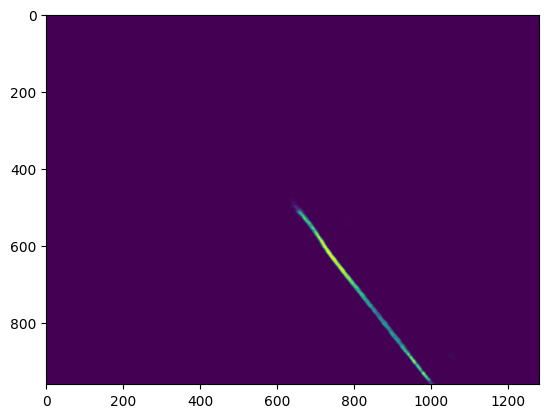

In [ ]:
%%timeit
img = cv2.imread('/content/carla_dataset/train/22.png')
plt.imshow(get_pred_for_mobilenet(learn.model,img)[0][2])

In [ ]:
%timeit get_pred_for_mobilenet(learn.model,img)

36.1 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Loading the model and testing model and funtions to create a ROI extraction function using the model and some functions

In [ ]:
# Specify the path to your .pth file
model_path = '/content/fastai_model_final.pth'

# Load the model
model = torch.load(model_path)

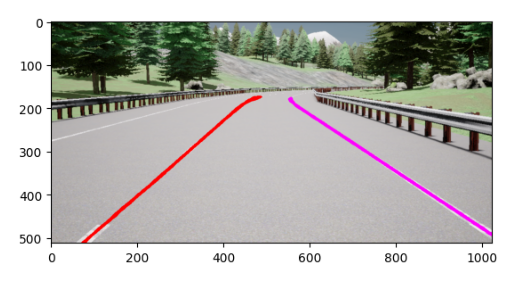

In [3]:
#Testing the loaded model on some individual images
import copy
back, left, right = get_pred_for_mobilenet(model,img)[0]
def ld_detection_overlay(image, left_mask, right_mask):
    res = copy.copy(image)
    res[left_mask > 0.3, :] = [0,0,255]
    res[right_mask > 0.3, :] = [0,0,255]
    return res
img = cv2.imread(str('/content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Adding code snip to  display the predicted segments only
%timeit get_pred_for_mobilenet(learn.model,img)
plt.imshow(ld_detection_overlay(img, left, right))

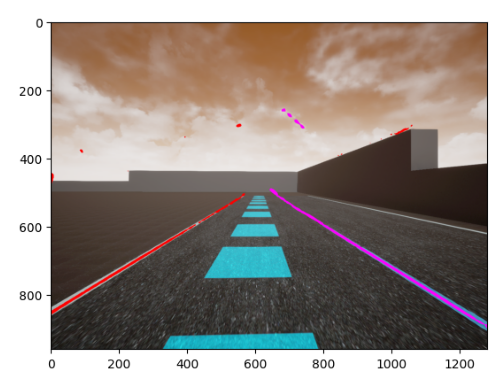

In [4]:
#Testing the loaded model on some individual images
import copy
back, left, right = get_pred_for_mobilenet(model,img)[0]
def ld_detection_overlay(image, left_mask, right_mask):
    res = copy.copy(image)
    res[left_mask > 0.3, :] = [0,0,255]
    res[right_mask > 0.3, :] = [0,0,255]
    return res
img = cv2.imread(str('/content/carla_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Adding code snip to  display the predicted segments only
%timeit get_pred_for_mobilenet(learn.model,img)
plt.imshow(ld_detection_overlay(img, left, right))

Now testing the model's prediction times for random images

In [ ]:
folder_path = "/content/carla_dataset/val"
num_iterations = 10
pred_times =[]
samples =[]
# Ensure the folder path is valid
if os.path.exists(folder_path):
    # Get a list of all image files in the folder
    image_files = [filename for filename in os.listdir(folder_path) if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    # Limit the loop to a specific number of iterations
    for _ in range(min(num_iterations, len(image_files))):
        # Choose a random image file from the list
        random_image = random.choice(image_files)

        # Construct the full path to the randomly chosen image file
        image_path = os.path.join(folder_path, random_image)

        # Open the image using Pillow
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        start_time = time.time()
        get_pred_for_mobilenet(model, img)
        end_time = time.time()
        predtime = end_time - start_time
        pred_times.append(predtime)
        samples.append(_)
else:
    print(f"The folder path {folder_path} does not exist.")

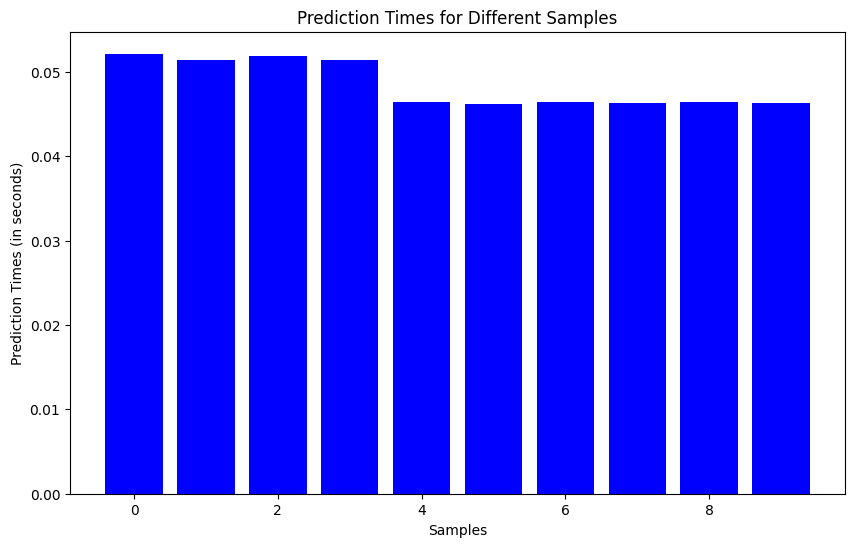

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(samples, pred_times, color='blue')
plt.xlabel('Samples')
plt.ylabel('Prediction Times (in seconds)')
plt.title('Prediction Times for Different Samples')
plt.show()

This is to show the image and the label for it


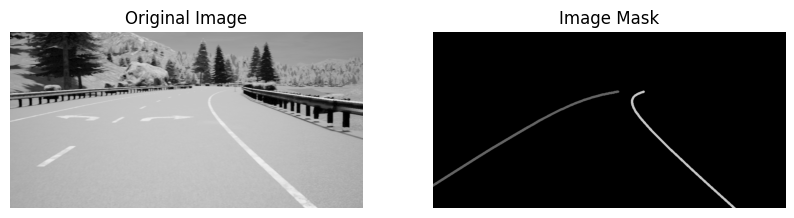

In [ ]:
print('This is to show the image and the label for it')
img=cv2.imread('/content/carla_dataset/val_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set.png')
mask = cv2.imread('/content/carla_dataset/val_label_gray/Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set_label.png')
# Display the original and reshaped images using Matplotlib
plt.figure(figsize=(10, 5))

# Original RGB Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Reshaped Grayscale Image
plt.subplot(1, 2, 2)
plt.imshow(mask*100)
plt.title('Image Mask')
plt.axis('off')

plt.show()

This part of the code is a combination of all the prediction part, the masking of the predicted part and using polly fill to fill in between the left and right boundaries the ROI from the image and all others are blacked out!

In [ ]:
# Use the function to extract left and right boundaries
#left_boundary, right_boundary = extract_lane_boundaries(left, right)

In [ ]:
# Create a single plot with two subplots side by side
plt.figure(figsize=(12, 6))

# Plot the left boundary on the left subplot
plt.subplot(1, 2, 1)
plt.imshow(left_boundary, cmap='gray')
plt.title('Left Lane Boundary')
plt.axis('off')

# Plot the right boundary on the right subplot
plt.subplot(1, 2, 2)
plt.imshow(right_boundary, cmap='gray')
plt.title('Right Lane Boundary')
plt.axis('off')

plt.show()

In [ ]:
%%time
# Load the original image
#image = image2 = cv2.imread('/content/carla_dataset/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1061_validation_set.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Create a binary mask for the region of interest (ROI) between left and right boundaries
roi_mask = (left_boundary | right_boundary).astype(np.uint8)

# Create a copy of the original image
image_with_roi = np.copy(image)

# Set all pixels outside the ROI to black
image_with_roi[roi_mask == 0] = [0, 0, 0]

# Overlay the left and right lane boundaries in red color
image_with_roi[left_boundary > 0] = [255, 201, 0]
image_with_roi[right_boundary > 0] = [255, 201, 0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image on the left subplot
axes[0].imshow(cv2.cvtColor(image_with_roi, cv2.COLOR_BGR2RGB))
axes[0].set_title('Image 1')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 2')
axes[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
print(image_with_roi.shape)

(512, 1024, 3)


In [ ]:
# Find the start coordinates of the left boundary
#left_start_x, left_start_y = left_x[0], left_y[0]

# Find the start coordinates of the right boundary
#right_start_x, right_start_y = right_x[0], right_y[0]

# Print the start coordinates of left and right boundaries
#print("Start Coordinates of Left Boundary (x, y):", left_start_x, left_start_y)
#print("Start Coordinates of Right Boundary (x, y):", right_start_x, right_start_y)

Start Coordinates of Left Boundary (x, y): 366 188
Start Coordinates of Right Boundary (x, y): 440 187


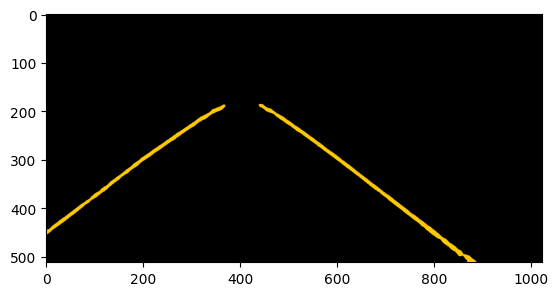

CPU times: user 262 ms, sys: 111 ms, total: 373 ms
Wall time: 248 ms


In [ ]:
#%%time
# Load the original image
#image = cv2.imread('/content/carla_dataset/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1061_validation_set.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a binary mask for the region of interest (ROI) between left and right boundaries
#roi_mask = (left_boundary | right_boundary).astype(np.uint8)

# Create a copy of the original image
#image_with_roi = np.copy(image)

# Set all pixels outside the ROI to black
#image_with_roi[roi_mask == 0] = [0, 0, 0]

# Overlay the left and right lane boundaries in red color
#image_with_roi[left_boundary > 0] = [255, 201, 0]
#image_with_roi[right_boundary > 0] = [255, 201, 0]

# Display the image with the ROI and lane boundaries
#plt.imshow(image_with_roi)
#plt.show()

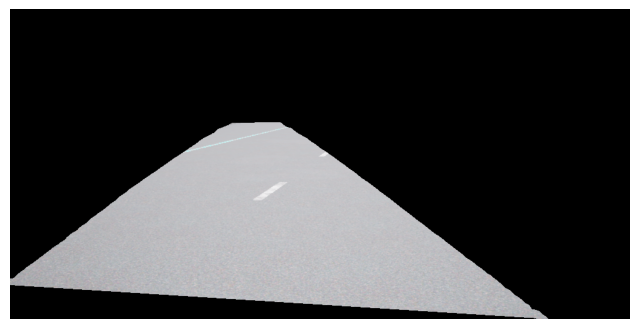

In [ ]:
# Find the coordinates of the left and right boundaries
left_y, left_x = np.where(left_boundary > 0)
right_y, right_x = np.where(right_boundary > 0)

# Create a black background mask with the same dimensions as the image
mask = np.zeros_like(image)

# Create a polygon for the left boundary
left_polygon = np.column_stack((left_x, left_y))

# Create a polygon for the right boundary (reverse the order to close the gap)
right_polygon = np.column_stack((right_x[::-1], right_y[::-1]))

# Combine the left and right polygons to fill the region between them
polygon_points = np.vstack((left_polygon, right_polygon))

# Use fillPoly to fill the region between the left and right boundaries
cv2.fillPoly(mask, [polygon_points], (255, 255, 255))

# Bitwise-AND your original image and the mask
result = cv2.bitwise_and(image, mask)

# Plot the resulting image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis('off')
plt.show()

In [ ]:
img = cv2.imread(str('/content/carla_dataset/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1062_validation_set.png'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
back, left, right = get_pred_for_mobilenet(learn.model,img)[0]
# Adding code snip to  display the predicted segments only
%timeit get_pred_for_mobilenet(learn.model,img)
plt.imshow(ld_detection_overlay(img, left, right))

# Use the function to extract left and right boundaries
left_boundary, right_boundary = extract_lane_boundaries(left, right)
roi_mask = (left_boundary | right_boundary).astype(np.uint8)

# Create a copy of the original image
image_with_roi = np.copy(img)

# Set all pixels outside the ROI to black
image_with_roi[roi_mask == 0] = [0, 0, 0]

# Overlay the left and right lane boundaries in red color
image_with_roi[left_boundary > 0] = [255, 201, 0]
image_with_roi[right_boundary > 0] = [255, 201, 0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image on the left subplot
#axes[0].imshow(cv2.cvtColor(image_with_roi, cv2.COLOR_BGR2RGB))
#axes[0].set_title('Image 1')
#axes[0].axis('off')

# Display the second image on the right subplot
#axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#axes[1].set_title('Image 2')
#axes[1].axis('off')

# Adjust the spacing between subplots
#plt.tight_layout()

# Show the figure
#plt.show()

# Find the coordinates of the left and right boundaries
left_y, left_x = np.where(left_boundary > 0)
right_y, right_x = np.where(right_boundary > 0)

# Create a black background mask with the same dimensions as the image
mask = np.zeros_like(img)

# Create a polygon for the left boundary
left_polygon = np.column_stack((left_x, left_y))

# Create a polygon for the right boundary (reverse the order to close the gap)
right_polygon = np.column_stack((right_x[::-1], right_y[::-1]))

# Combine the left and right polygons to fill the region between them
polygon_points = np.vstack((left_polygon, right_polygon))

# Use fillPoly to fill the region between the left and right boundaries
cv2.fillPoly(mask, [polygon_points], (255, 255, 255))

# Bitwise-AND your original image and the mask
result = cv2.bitwise_and(img, mask)

# Plot the resulting image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis('off')
plt.show()

This is the part of the Inference of model.

In [ ]:
import torch
import cv2
import numpy as np
import copy

In [ ]:
# function to load the torch model given the model path
def load_model(model_path):
    model = torch.load(model_path)
    model.eval()
    return model
#_____________________
def ld_detection_overlay(image, left_mask, right_mask):
    res = copy.copy(image)
    res[left_mask > 0.3, :] = [0,0,255]
    res[right_mask > 0.3, :] = [255,0,255]
    return res
#_____________________
def get_pred_for_mobilenet(model, img_array):
    with torch.no_grad():
        image_tensor = img_array.transpose(2,0,1).astype('float32')/255
        x_tensor = torch.from_numpy(image_tensor).to("cuda").unsqueeze(0)
        model_output = F.softmax( model.forward(x_tensor), dim=1 ).cpu().numpy()
    return model_output
#____________________


In [ ]:
model_path = '/content/fastai_model.pth'
loaded_model = load_model(model_path)

16.8 ms ± 311 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


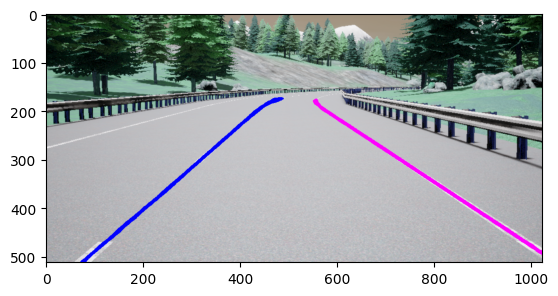

In [ ]:
back, left, right = get_pred_for_mobilenet(loaded_model,img)[0]
img = cv2.imread(str('/content/carla_dataset/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1062_validation_set.png'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Adding code snip to  display the predicted segments only
%timeit get_pred_for_mobilenet(loaded_model,img)
plt.imshow(ld_detection_overlay(img, left, right))

Now doing some testing and ROI isolation on custom environment images

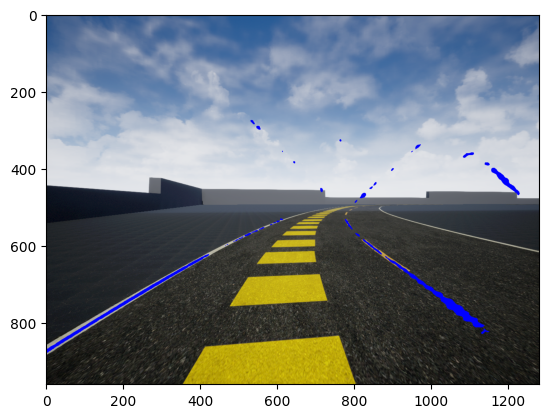

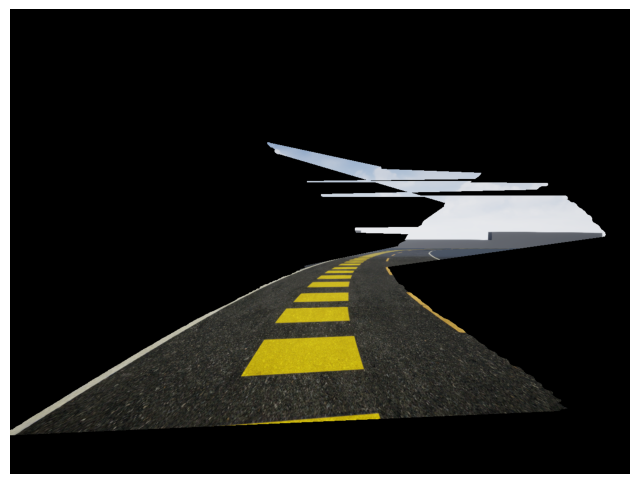

CPU times: user 844 ms, sys: 440 ms, total: 1.28 s
Wall time: 779 ms


In [ ]:
%%time
#img = cv2.imread(str('/content/carla_dataset/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_3138_validation_set.png'))
img = cv2.imread('/content/curved_33.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
back, left, right = get_pred_for_mobilenet(learn,img)[0]
# Adding code snip to  display the predicted segments only
get_pred_for_mobilenet(learn,img)
plt.imshow(ld_detection_overlay(img, left, right))

# Use the function to extract left and right boundaries
left_boundary, right_boundary = extract_lane_boundaries(left, right)
roi_mask = (left_boundary | right_boundary).astype(np.uint8)

# Create a copy of the original image
image_with_roi = np.copy(img)

# Set all pixels outside the ROI to black
image_with_roi[roi_mask == 0] = [0, 0, 0]

# Overlay the left and right lane boundaries in red color
image_with_roi[left_boundary > 0] = [255, 201, 0]
image_with_roi[right_boundary > 0] = [255, 201, 0]

# Create a figure with two subplots
#fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image on the left subplot
#axes[0].imshow(cv2.cvtColor(image_with_roi, cv2.COLOR_BGR2RGB))
#axes[0].set_title('Image 1')
#axes[0].axis('off')

# Display the second image on the right subplot
#axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#axes[1].set_title('Image 2')
#axes[1].axis('off')

# Adjust the spacing between subplots
#plt.tight_layout()

# Show the figure
#plt.show()

# Find the coordinates of the left and right boundaries
left_y, left_x = np.where(left_boundary > 0)
right_y, right_x = np.where(right_boundary > 0)

# Create a black background mask with the same dimensions as the image
mask = np.zeros_like(img)

# Create a polygon for the left boundary
left_polygon = np.column_stack((left_x, left_y))

# Create a polygon for the right boundary (reverse the order to close the gap)
right_polygon = np.column_stack((right_x[::-1], right_y[::-1]))

# Combine the left and right polygons to fill the region between them
polygon_points = np.vstack((left_polygon, right_polygon))

# Use fillPoly to fill the region between the left and right boundaries
cv2.fillPoly(mask, [polygon_points], (255, 255, 255))

# Bitwise-AND your original image and the mask
result = cv2.bitwise_and(img, mask)

# Plot the resulting image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis('off')
plt.show()

From what we can see that there are alot of noise in the top of the image so some more image processing is needed and testing the islation again 

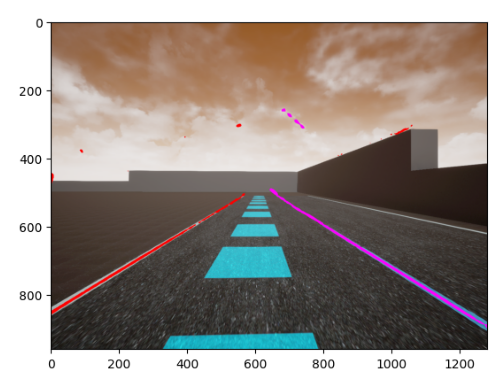

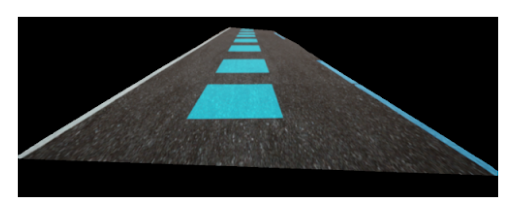

In [14]:
def connect_pixels(binary_mask, iterations=3):
    kernel = np.ones((5, 5), np.uint8)
    connected_mask = cv2.dilate(binary_mask, kernel, iterations=iterations)
    connected_mask = cv2.erode(connected_mask, kernel, iterations=iterations)
    return connected_mask
#img = cv2.imread(str('/content/carla_dataset/val/Town04_Clear_Noon_09_09_2020_14_57_22_frame_3138_validation_set.png'))
img = cv2.imread('/content/curved_341.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape
# cropping the image horizontaly to have only the bottom part of the image which contains the lane 
crop_pixel_value = 500
crop_pixel_value = min(crop_pixel_value, img.shape[1])
img_cropped = img[:, :crop_pixel_value, :]
# end of added image processing 
back, left, right = get_pred_for_mobilenet(learn,img)[0]
# Adding code snip to  display the predicted segments only
get_pred_for_mobilenet(learn,img)
plt.imshow(ld_detection_overlay(img, left, right))

# Use the function to extract left and right boundaries
left_boundary, right_boundary = extract_lane_boundaries(left, right)
roi_mask = (left_boundary | right_boundary).astype(np.uint8)

# Create a copy of the original image
image_with_roi = np.copy(img)

# Set all pixels outside the ROI to black
image_with_roi[roi_mask == 0] = [0, 0, 0]

# Overlay the left and right lane boundaries in red color
image_with_roi[left_boundary > 0] = [255, 201, 0]
image_with_roi[right_boundary > 0] = [255, 201, 0]
# Connect the pixels in left and right boundaries
connected_left = connect_pixels(left_boundary)
connected_right = connect_pixels(right_boundary)

# Find the coordinates of the connected left and right boundaries
left_y, left_x = np.where(connected_left > 0)
right_y, right_x = np.where(connected_right > 0)

# Create a figure with two subplots
#fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image on the left subplot
#axes[0].imshow(cv2.cvtColor(image_with_roi, cv2.COLOR_BGR2RGB))
#axes[0].set_title('Image 1')
#axes[0].axis('off')

# Display the second image on the right subplot
#axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#axes[1].set_title('Image 2')
#axes[1].axis('off')

# Adjust the spacing between subplots
#plt.tight_layout()

# Show the figure
#plt.show()

# Find the coordinates of the left and right boundaries
#left_y, left_x = np.where(left_boundary > 0)
#right_y, right_x = np.where(right_boundary > 0)

# Create a black background mask with the same dimensions as the image
mask = np.zeros_like(img)

# Create a polygon for the left boundary
left_polygon = np.column_stack((left_x, left_y))

# Create a polygon for the right boundary (reverse the order to close the gap)
right_polygon = np.column_stack((right_x[::-1], right_y[::-1]))

# Combine the left and right polygons to fill the region between them
polygon_points = np.vstack((left_polygon, right_polygon))

# Use fillPoly to fill the region between the left and right boundaries
cv2.fillPoly(mask, [polygon_points], (255, 255, 255))

# Bitwise-AND your original image and the mask
result = cv2.bitwise_and(img, mask)

# Plot the resulting image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis('off')
plt.show()

In [ ]:
# function to load the torch model given the model path
def load_model(model_path):
    model = torch.load(model_path)
    model.eval()
    return model
#_____________________
def ld_detection_overlay(image, left_mask, right_mask):
    res = copy.copy(image)
    res[left_mask > 0.3, :] = [0,0,255]
    res[right_mask > 0.3, :] = [255,0,255]
    return res
#_____________________
def get_pred_for_mobilenet(model, img_array):
    with torch.no_grad():
        image_tensor = img_array.transpose(2,0,1).astype('float32')/255
        x_tensor = torch.from_numpy(image_tensor).to("cuda").unsqueeze(0)
        model_output = F.softmax( model.forward(x_tensor), dim=1 ).cpu().numpy()
    return model_output
#____________________
def extract_lane_boundaries(left_mask, right_mask, threshold=0.3):
    # Threshold the masks to separate left and right lanes
    left_lane = (left_mask > threshold).astype(np.uint8)
    right_lane = (right_mask > threshold).astype(np.uint8)
    left_boundary = left_lane.copy() # Taking a copy of the extracted boundaries
    right_boundary = right_lane.copy()

    # Find the boundary of the left lane
    contours, _ = cv2.findContours(left_boundary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        left_boundary = cv2.drawContours(left_boundary, contours, -1, (1), thickness=cv2.FILLED)

    # Find the boundary of the right lane
    contours, _ = cv2.findContours(right_boundary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        right_boundary = cv2.drawContours(right_boundary, contours, -1, (1), thickness=cv2.FILLED)

    return left_boundary, right_boundary